## Install required libraries

In [1]:
!pip install kaggle

## Importing required libraries

In [2]:
import zipfile
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from sklearn.metrics import mean_squared_error

## Downloading dataset

In [35]:
!kaggle datasets download -d mczielinski/bitcoin-historical-data

Dataset URL: https://www.kaggle.com/datasets/mczielinski/bitcoin-historical-data
License(s): CC-BY-SA-4.0
bitcoin-historical-data.zip: Skipping, found more recently modified local copy (use --force to force download)


In [36]:
with zipfile.ZipFile('bitcoin-historical-data.zip', 'r') as zip_ref:
    zip_ref.extractall('bitcoin-historical-data')

## Reading dataset

In [47]:
file_path = 'bitcoin-historical-data/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv'
df = pd.read_csv(file_path)

In [48]:
df.head()

,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
0,1325317920,4.39,4.39,4.39,4.39,0.455581,2.0,4.39
1,1325317980,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1325318040,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1325318100,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1325318160,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Dataset description

Este dataset contém dados históricos de preços do Bitcoin coletados da exchange Bitstamp em intervalos de 1 minuto, cobrindo o período de 1º de janeiro de 2012 a 31 de março de 2021. O dataset tem um total de 4.857.377 registros, oferecendo uma visão abrangente do comportamento do Bitcoin ao longo dos anos.

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4857377 entries, 0 to 4857376
Data columns (total 8 columns):
 #   Column             Dtype  
---  ------             -----  
 0   Timestamp          int64  
 1   Open               float64
 2   High               float64
 3   Low                float64
 4   Close              float64
 5   Volume_(BTC)       float64
 6   Volume_(Currency)  float64
 7   Weighted_Price     float64
dtypes: float64(7), int64(1)
memory usage: 296.5 MB


In [40]:
df.shape

(4857377, 8)

<b>Descrição das Colunas</b>

1. <b>Timestamp (int64):</b>

* Descrição: Marca temporal representando o número de segundos desde 01 de janeiro de 1970 (Unix epoch). Cada valor nesta coluna corresponde ao início de um intervalo de 1 minuto.
* Utilidade: Essencial para ordenar os dados cronologicamente e para análises temporais, como a criação de séries temporais.

2. <b>Open (float64):</b>

* Descrição: Preço de abertura do Bitcoin no início do intervalo de 1 minuto.
* Utilidade: Utilizado para analisar como o preço do Bitcoin se comportou ao longo do tempo, especialmente no início de cada intervalo de 1 minuto.

3. <b>High (float64):</b>

* Descrição: Preço máximo alcançado pelo Bitcoin durante o intervalo de 1 minuto.
* Utilidade: Importante para identificar picos de preço e volatilidade durante cada minuto.

4. <b>Low (float64):</b>

* Descrição: Preço mínimo alcançado pelo Bitcoin durante o intervalo de 1 minuto.
* Utilidade: Útil para identificar o valor mínimo que o Bitcoin atingiu em cada intervalo, auxiliando na análise de volatilidade.

6. <b>Close (float64):</b>

* Descrição: Preço de fechamento do Bitcoin no final do intervalo de 1 minuto.
* Utilidade: Essencial para muitas análises financeiras, como a construção de séries temporais e para a previsão de preços futuros.

7. <b>Volume_(BTC) (float64):</b>

* Descrição: Volume de Bitcoin negociado durante o intervalo de 1 minuto.
* Utilidade: Indicador da quantidade de negociação em um determinado período, importante para análises de liquidez e atividade de mercado.

8. <b>Volume_(Currency) (float64):</b>

* Descrição: Volume total da moeda (geralmente USD) negociado durante o intervalo de 1 minuto.
* Utilidade: Assim como o Volume_(BTC), mas representado em termos monetários, útil para entender o valor total das negociações em moeda fiduciária.

9. <b>Weighted_Price (float64):</b>

* Descrição: Preço ponderado do Bitcoin durante o intervalo de 1 minuto, calculado como a média ponderada dos preços de negociação com base no volume.
* Utilidade: Proporciona uma visão mais precisa do preço médio, levando em conta o volume negociado, o que pode ser mais representativo do valor de mercado durante o período.

## Data preprocessing

In [49]:
df = df[['Timestamp', 'Open', 'High', 'Low', 'Close', 'Volume_(BTC)', 'Volume_(Currency)', 'Weighted_Price']]

# Tratando valores nulos
df.dropna(inplace=True)

# Convertendo o timestamp para datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df.set_index('Timestamp', inplace=True)

# Selecionando uma amostra menor do dataset
sample_size = 100000
df_sample = df.tail(sample_size)

scaler_all = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler_all.fit_transform(df_sample)

scaler_close = MinMaxScaler(feature_range=(0, 1))
df_close = df_sample[['Close']]
scaled_close = scaler_close.fit_transform(df_close)

# Dividindo o dataset em treino e teste
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Dividindo o dataset para a coluna 'Close'
train_close = scaled_close[:train_size]
test_close = scaled_close[train_size:]

# Função para criar janelas de dados
def create_dataset(data, close_data, time_step=60):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        X.append(data[i:(i + time_step), :])
        Y.append(close_data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 60
X_train, y_train = create_dataset(train_data, train_close, time_step)
X_test, y_test = create_dataset(test_data, test_close, time_step)

## Model training

In [50]:
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(time_step, X_train.shape[2])))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

model.compile(optimizer='adam', loss='mean_squared_error')

history = model.fit(X_train, y_train, batch_size=64, epochs=10, validation_data=(X_test, y_test))

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 16s 11ms/step - loss: 0.0060 - val_loss: 2.3400e-05
Epoch 2/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 10ms/step - loss: 2.3319e-05 - val_loss: 2.0398e-04
Epoch 3/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 2.6059e-05 - val_loss: 7.4550e-05
Epoch 4/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 2.6104e-05 - val_loss: 4.0285e-05
Epoch 5/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 9ms/step - loss: 2.6948e-05 - val_loss: 2.3629e-05
Epoch 6/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 21s 10ms/step - loss: 2.1998e-05 - val_loss: 5.8489e-05
Epoch 7/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 19s 9ms/step - loss: 2.0103e-05 - val_loss: 6.9310e-06
Epoch 8/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 22s 10ms/step - loss: 1.6016e-05 - val_loss: 1.9208e-05
Epoch 9/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 12s 10ms/step - loss: 1.4991e-05 - val_loss: 1.1921e-04
Epoch 10/10
1250/1250 ━━━━━━━━━━━━━━━━━━━━ 20s 10ms/step - loss: 1.4416e-05 - val_loss: 2.0516e-04


## Model evaluation

### Inference

In [51]:
predicted_prices = model.predict(X_test)

# Desnormalizando os valores preditos usando o scaler específico da coluna 'Close'
predicted_prices = scaler_close.inverse_transform(predicted_prices)

# Desnormalizando os valores reais da coluna 'Close'
real_prices = scaler_close.inverse_transform(y_test.reshape(-1, 1))

624/624 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


### Evaluation metric

A métrica Mean Squared Error (MSE) é ideal para o problema de previsão de preços de Bitcoin porque se trata de um problema de regressão, onde o objetivo é prever valores numéricos contínuos. O MSE mede a média dos quadrados das diferenças entre os valores reais e preditos, penalizando erros maiores de forma mais severa. Além disso, o MSE é fácil de interpretar e suave, facilitando a otimização do modelo durante o treinamento, tornando-o uma escolha comum para redes neurais como LSTMs. Quanto menor o valor do MSE, mais precisas são as previsões feitas pelo modelo.

Além do MSE, três métricas alternativas para problemas de regressão são o Mean Absolute Error (MAE), que mede o erro absoluto médio e é menos sensível a outliers; o Root Mean Squared Error (RMSE), que é a raiz quadrada do MSE, tornando os erros mais interpretáveis na mesma escala dos valores reais; e o Mean Absolute Percentage Error (MAPE), que calcula o erro absoluto em termos percentuais, sendo útil para comparar erros em diferentes escalas, mas pode ser instável para valores próximos de zero.

In [54]:
mse = mean_squared_error(real_prices, predicted_prices)
rmse = np.sqrt(mse)
print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error: {rmse}')

Mean Squared Error: 222753.21164596258
Root Mean Squared Error: 471.9673840912766


### Plotting predictions

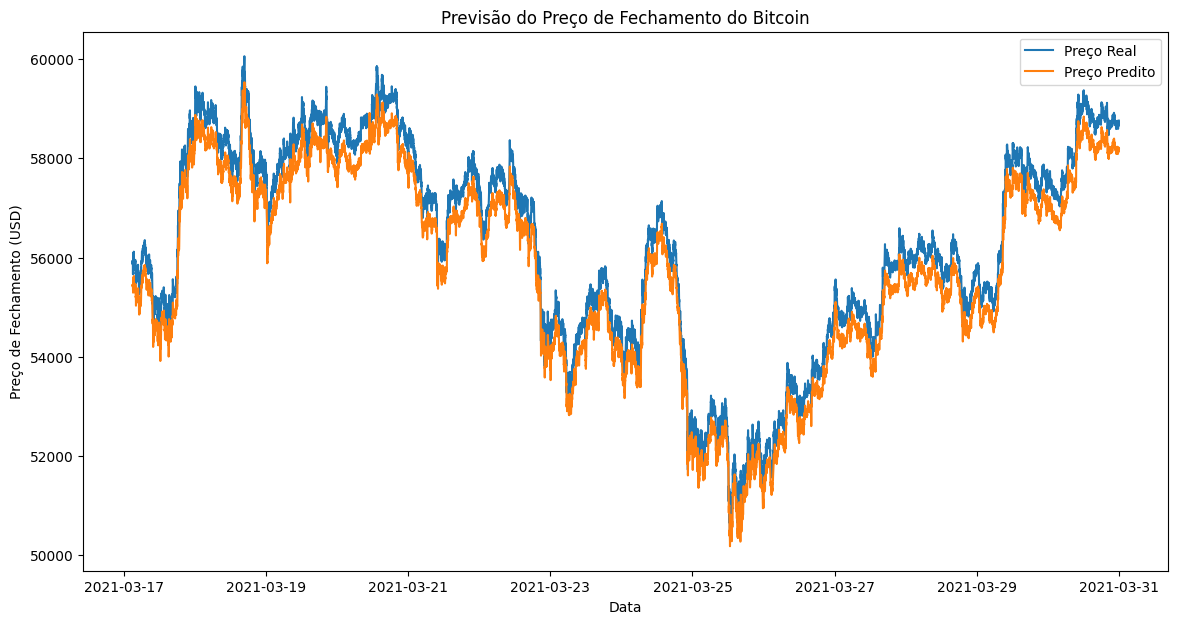

In [55]:
plt.figure(figsize=(14,7))
plt.plot(df_sample.index[-len(real_prices):], real_prices, label='Preço Real')
plt.plot(df_sample.index[-len(predicted_prices):], predicted_prices, label='Preço Predito')
plt.xlabel('Data')
plt.ylabel('Preço de Fechamento (USD)')
plt.title('Previsão do Preço de Fechamento do Bitcoin')
plt.legend()
plt.show()